In [2]:
import torch
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device:", torch.cuda.get_device_name(0))
    print("GPU Memory:", torch.cuda.get_device_properties(0).total_memory / 1e9, "GB")

CUDA Available: True
GPU Device: Tesla T4
GPU Memory: 15.835660288 GB


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm
import time
import gc

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

# Define data augmentation and preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset with proper num_workers for Colab
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128,
                        shuffle=True, num_workers=2,
                        pin_memory=True)  # Enable pin_memory for faster data transfer to GPU

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128,
                       shuffle=False, num_workers=2,
                       pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Vision Transformer implementation
class PatchEmbed(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, embed_dim=192):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(in_channels, embed_dim,
                             kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False,
                 drop=0., attn_drop=0., act_layer=nn.GELU):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias,
                             attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            act_layer(),
            nn.Dropout(drop),
            nn.Linear(mlp_hidden_dim, dim),
            nn.Dropout(drop)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=192, depth=12, num_heads=8, mlp_ratio=4.,
                 qkv_bias=True, drop_rate=0., attn_drop_rate=0.):
        super().__init__()
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size,
                                    in_channels=in_channels, embed_dim=embed_dim)
        num_patches = self.patch_embed.n_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        self.blocks = nn.ModuleList([
            TransformerBlock(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio,
                qkv_bias=qkv_bias, drop=drop_rate, attn_drop=attn_drop_rate)
            for i in range(depth)])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

        # Initialize weights
        nn.init.trunc_normal_(self.pos_embed, std=.02)
        nn.init.trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)
        x = x[:, 0]  # Take only the cls token
        x = self.head(x)
        return x

# Training and evaluation functions
def train_one_epoch(model, trainloader, criterion, optimizer, device, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}', leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({
            'loss': f'{running_loss/len(pbar):.3f}',
            'acc': f'{100.*correct/total:.2f}%'
        })

    return running_loss/len(trainloader), 100.*correct/total

def evaluate(model, testloader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    avg_loss = test_loss/len(testloader)
    acc = 100.*correct/total
    return avg_loss, acc

Using device: cuda
Training on: Tesla T4
Starting training...


Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 1/20
Train Loss: 1.891 | Train Acc: 28.36%
Test Loss: 1.709 | Test Acc: 35.72%
Best Acc: 35.72%
Learning Rate: 0.000994


Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 2/20
Train Loss: 1.670 | Train Acc: 37.07%
Test Loss: 1.582 | Test Acc: 41.61%
Best Acc: 41.61%
Learning Rate: 0.000976


Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 3/20
Train Loss: 1.528 | Train Acc: 43.48%
Test Loss: 1.449 | Test Acc: 47.44%
Best Acc: 47.44%
Learning Rate: 0.000946


Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 4/20
Train Loss: 1.443 | Train Acc: 46.91%
Test Loss: 1.364 | Test Acc: 51.12%
Best Acc: 51.12%
Learning Rate: 0.000905


Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 5/20
Train Loss: 1.378 | Train Acc: 49.81%
Test Loss: 1.303 | Test Acc: 52.80%
Best Acc: 52.80%
Learning Rate: 0.000854


Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 6/20
Train Loss: 1.338 | Train Acc: 51.49%
Test Loss: 1.310 | Test Acc: 52.81%
Best Acc: 52.81%
Learning Rate: 0.000794


Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 7/20
Train Loss: 1.286 | Train Acc: 53.21%
Test Loss: 1.269 | Test Acc: 54.42%
Best Acc: 54.42%
Learning Rate: 0.000727


Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 8/20
Train Loss: 1.241 | Train Acc: 54.96%
Test Loss: 1.250 | Test Acc: 55.52%
Best Acc: 55.52%
Learning Rate: 0.000655


Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 9/20
Train Loss: 1.198 | Train Acc: 56.52%
Test Loss: 1.187 | Test Acc: 57.36%
Best Acc: 57.36%
Learning Rate: 0.000578


Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 10/20
Train Loss: 1.156 | Train Acc: 57.83%
Test Loss: 1.111 | Test Acc: 60.50%
Best Acc: 60.50%
Learning Rate: 0.000500


Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 11/20
Train Loss: 1.117 | Train Acc: 59.78%
Test Loss: 1.098 | Test Acc: 61.17%
Best Acc: 61.17%
Learning Rate: 0.000422


Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 12/20
Train Loss: 1.076 | Train Acc: 61.22%
Test Loss: 1.026 | Test Acc: 63.57%
Best Acc: 63.57%
Learning Rate: 0.000345


Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 13/20
Train Loss: 1.033 | Train Acc: 62.83%
Test Loss: 0.984 | Test Acc: 64.71%
Best Acc: 64.71%
Learning Rate: 0.000273


Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 14/20
Train Loss: 1.004 | Train Acc: 63.91%
Test Loss: 0.966 | Test Acc: 65.22%
Best Acc: 65.22%
Learning Rate: 0.000206


Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 15/20
Train Loss: 0.967 | Train Acc: 65.36%
Test Loss: 0.940 | Test Acc: 66.55%
Best Acc: 66.55%
Learning Rate: 0.000146


Epoch 16:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 16/20
Train Loss: 0.934 | Train Acc: 66.65%
Test Loss: 0.909 | Test Acc: 67.58%
Best Acc: 67.58%
Learning Rate: 0.000095


Epoch 17:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 17/20
Train Loss: 0.913 | Train Acc: 67.52%
Test Loss: 0.892 | Test Acc: 68.13%
Best Acc: 68.13%
Learning Rate: 0.000054


Epoch 18:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 18/20
Train Loss: 0.900 | Train Acc: 68.01%
Test Loss: 0.871 | Test Acc: 68.81%
Best Acc: 68.81%
Learning Rate: 0.000024


Epoch 19:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 19/20
Train Loss: 0.879 | Train Acc: 68.48%
Test Loss: 0.876 | Test Acc: 68.87%
Best Acc: 68.87%
Learning Rate: 0.000006


Epoch 20:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch: 20/20
Train Loss: 0.871 | Train Acc: 68.87%
Test Loss: 0.869 | Test Acc: 68.90%
Best Acc: 68.90%
Learning Rate: 0.000000

Training completed in 23.91 minutes
Best accuracy: 68.90%


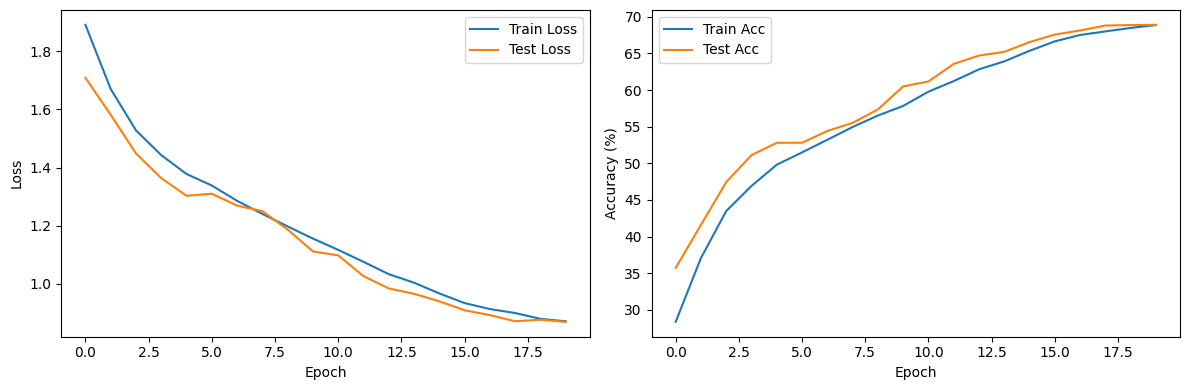

In [6]:
def main():
    # Hyperparameters
    num_epochs = 20
    learning_rate = 1e-3
    weight_decay = 5e-4

    print(f"Using device: {device}")
    print(f"Training on: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

    # Create model
    model = VisionTransformer(
        img_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=192,
        depth=12,
        num_heads=8,
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.1,
        attn_drop_rate=0.1
    ).to(device)

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate,
                           weight_decay=weight_decay)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Training loop
    best_acc = 0
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []

    # Create directory for saving models if it doesn't exist
    import os
    if not os.path.exists('models'):
        os.makedirs('models')

    print("Starting training...")
    start_time = time.time()

    try:
        for epoch in range(num_epochs):
            # Train
            train_loss, train_acc = train_one_epoch(model, trainloader,
                                                  criterion, optimizer,
                                                  device, epoch)

            # Evaluate
            test_loss, test_acc = evaluate(model, testloader, criterion, device)

            # Update learning rate
            scheduler.step()

            # Save metrics
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            test_losses.append(test_loss)
            test_accs.append(test_acc)

            # Save best model
            if test_acc > best_acc:
                best_acc = test_acc
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_acc': best_acc,
                }, 'models/best_vit_cifar10.pth')

            # Print progress
            print(f'\nEpoch: {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
            print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.2f}%')
            print(f'Best Acc: {best_acc:.2f}%')
            print(f'Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

            # Clear GPU cache periodically
            if (epoch + 1) % 10 == 0:
                torch.cuda.empty_cache()
                gc.collect()

    except KeyboardInterrupt:
        print('Training interrupted by user')

    finally:
        total_time = time.time() - start_time
        print(f'\nTraining completed in {total_time/60:.2f} minutes')
        print(f'Best accuracy: {best_acc:.2f}%')

        # Plot training curves
        import matplotlib.pyplot as plt

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_accs, label='Train Acc')
        plt.plot(test_accs, label='Test Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_curves.png')
        plt.show()

if __name__ == '__main__':
    main()

<ipython-input-7-dd31b82e815f>:158: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('models/best_vit_cifar10.pth')


Loaded model from epoch 19 with accuracy 68.90%
Starting model evaluation...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Detailed Classification Metrics:

Per-class metrics:
--------------------------------------------------------------------------------

Class: plane
Precision: 0.685
Recall: 0.758
F1-Score: 0.720

Class: car
Precision: 0.801
Recall: 0.794
F1-Score: 0.798

Class: bird
Precision: 0.579
Recall: 0.602
F1-Score: 0.590

Class: cat
Precision: 0.571
Recall: 0.442
F1-Score: 0.498

Class: deer
Precision: 0.659
Recall: 0.592
F1-Score: 0.623

Class: dog
Precision: 0.579
Recall: 0.621
F1-Score: 0.599

Class: frog
Precision: 0.676
Recall: 0.828
F1-Score: 0.745

Class: horse
Precision: 0.753
Recall: 0.676
F1-Score: 0.712

Class: ship
Precision: 0.795
Recall: 0.832
F1-Score: 0.813

Class: truck
Precision: 0.784
Recall: 0.745
F1-Score: 0.764

Overall metrics:
--------------------------------------------------------------------------------
Accuracy: 0.689

Macro Average:
Precision: 0.688
Recall: 0.689
F1-Score: 0.686

Plotting confusion matrix...


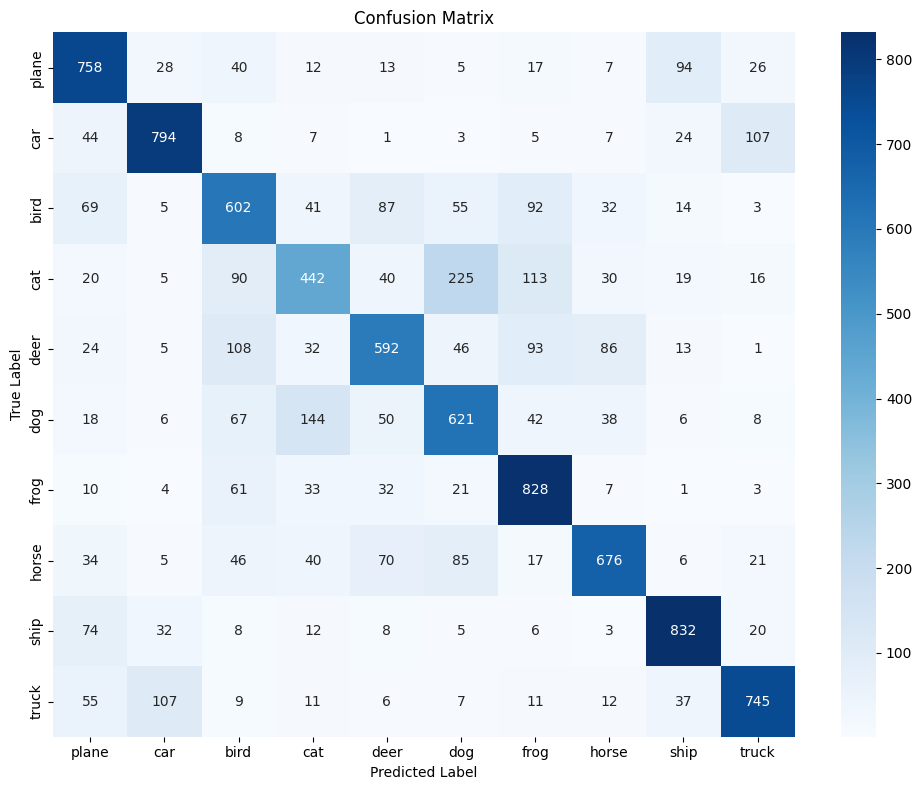


Plotting metrics by class...


<Figure size 1200x600 with 0 Axes>

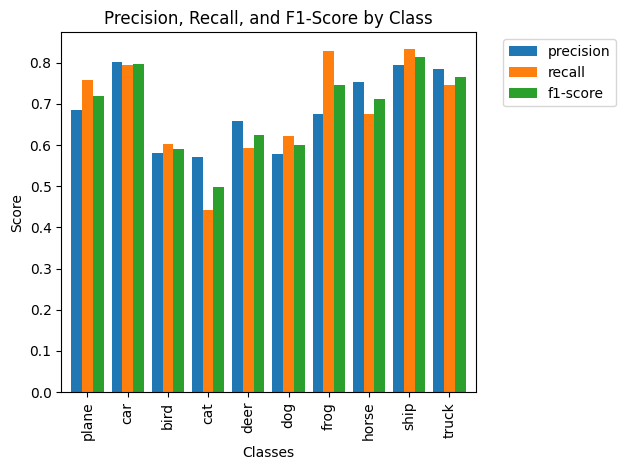


Visualizing example predictions...


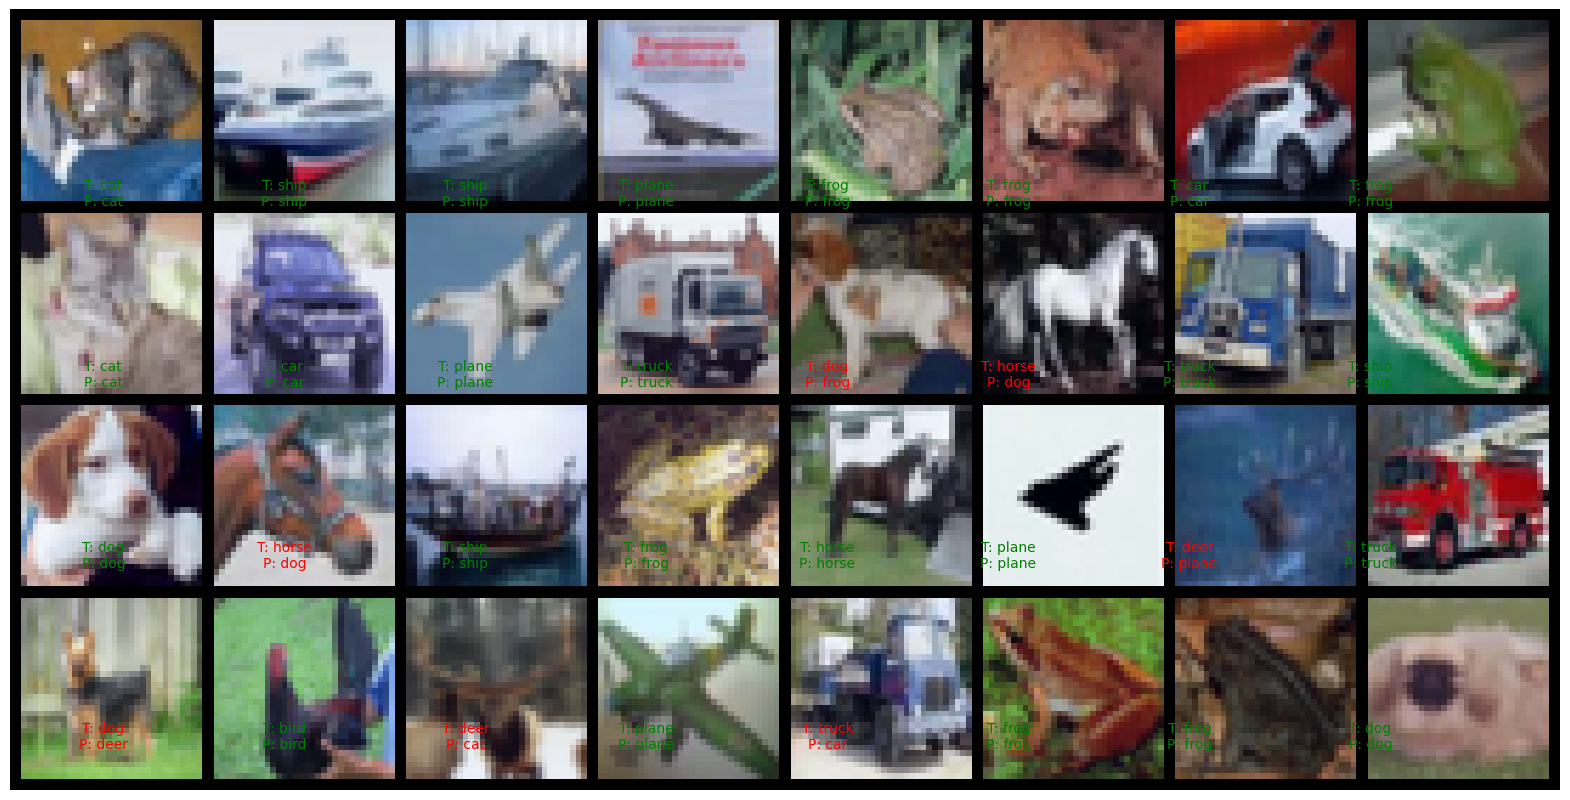

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import pandas as pd

def evaluate_model_detailed(model, testloader, device, classes):
    model.eval()
    all_preds = []
    all_labels = []
    example_images = []
    pred_labels = []
    true_labels = []

    # Get predictions
    with torch.no_grad():
        for i, (images, labels) in enumerate(tqdm(testloader, desc='Evaluating')):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            # Store predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Store some example images for visualization
            if i == 0:  # Store first batch
                example_images = images.cpu()[:32]  # Store up to 32 images
                pred_labels = predicted.cpu()[:32]
                true_labels = labels.cpu()[:32]

    # Calculate metrics
    cm = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds,
                                      target_names=classes,
                                      output_dict=True)

    return {
        'confusion_matrix': cm,
        'classification_report': class_report,
        'example_images': example_images,
        'pred_labels': pred_labels,
        'true_labels': true_labels
    }

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()

def plot_metrics(classification_report):
    metrics_df = pd.DataFrame(classification_report).transpose()
    metrics_df = metrics_df.drop('support', axis=1)  # Remove support column

    # Plot precision, recall, and f1-score for each class
    plt.figure(figsize=(12, 6))
    metrics_df.iloc[:-3].plot(kind='bar', width=0.8)
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig('metrics_by_class.png')
    plt.show()

def visualize_predictions(example_images, pred_labels, true_labels, classes):
    # Create a grid of images
    plt.figure(figsize=(20, 20))
    grid = make_grid(example_images, nrow=8, normalize=True)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')

    # Add labels
    for idx in range(len(pred_labels)):
        true_class = classes[true_labels[idx]]
        pred_class = classes[pred_labels[idx]]
        color = 'green' if true_labels[idx] == pred_labels[idx] else 'red'
        plt.text(idx % 8 * 32 + 16, idx // 8 * 32 + 32,
                f'T: {true_class}\nP: {pred_class}',
                color=color, ha='center', va='center')

    plt.savefig('prediction_examples.png')
    plt.show()

def print_metrics_summary(classification_report):
    # Create a formatted summary of the metrics
    metrics_df = pd.DataFrame(classification_report)

    print("\nDetailed Classification Metrics:")
    print("\nPer-class metrics:")
    print("-" * 80)
    for cls in metrics_df.columns[:-3]:
        print(f"\nClass: {cls}")
        print(f"Precision: {metrics_df[cls]['precision']:.3f}")
        print(f"Recall: {metrics_df[cls]['recall']:.3f}")
        print(f"F1-Score: {metrics_df[cls]['f1-score']:.3f}")

    print("\nOverall metrics:")
    print("-" * 80)
    print(f"Accuracy: {metrics_df['accuracy']['precision']:.3f}")
    print("\nMacro Average:")
    print(f"Precision: {metrics_df['macro avg']['precision']:.3f}")
    print(f"Recall: {metrics_df['macro avg']['recall']:.3f}")
    print(f"F1-Score: {metrics_df['macro avg']['f1-score']:.3f}")

def evaluate_and_visualize(model, testloader, device, classes):
    """
    Comprehensive evaluation and visualization function
    """
    print("Starting model evaluation...")

    # Get all evaluation results
    results = evaluate_model_detailed(model, testloader, device, classes)

    # 1. Print detailed metrics summary
    print_metrics_summary(results['classification_report'])

    # 2. Plot confusion matrix
    print("\nPlotting confusion matrix...")
    plot_confusion_matrix(results['confusion_matrix'], classes)

    # 3. Plot metrics by class
    print("\nPlotting metrics by class...")
    plot_metrics(results['classification_report'])

    # 4. Visualize example predictions
    print("\nVisualizing example predictions...")
    visualize_predictions(results['example_images'],
                        results['pred_labels'],
                        results['true_labels'],
                        classes)

def evaluate_saved_model():
    # Load the best model
    model = VisionTransformer(
        img_size=32,
        patch_size=4,
        in_channels=3,
        num_classes=10,
        embed_dim=192,
        depth=12,
        num_heads=8,
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.1,
        attn_drop_rate=0.1
    ).to(device)

    # Load the saved state dict
    checkpoint = torch.load('models/best_vit_cifar10.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded model from epoch {checkpoint['epoch']} with accuracy {checkpoint['best_acc']:.2f}%")

    # Evaluate and visualize
    evaluate_and_visualize(model, testloader, device, classes)

if __name__ == '__main__':
    evaluate_saved_model()